In [1]:
import torch;
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import pandas as pd
import torchvision.models as models 
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.optim import lr_scheduler
import seaborn as sns
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import copy
from tqdm import tqdm
#from model import VAE

import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from dataloader import *
from model import *

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
#only on validation set
csv_path = 'progress.csv'
img_path = '/home/vip/sayan-mandal/datasets/obj_criteria/good_reduced/'

CDL = CLUnivDataLoader(csv_path, img_path, transform = transforms.Compose([transforms.Resize(64),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),timestep=5,n=3)

#random sampler
batch_size = 64
validation_split = .2
test_split = .2
train_split = 1-validation_split-test_split
shuffle_dataset = True

# Creating data indices for training and validation splits:
dataset_size = len(CDL)
indices = list(range(dataset_size))
split_train = int(np.floor(train_split * dataset_size))
split_valid = int(np.floor((train_split+validation_split) * dataset_size))
if shuffle_dataset :
    np.random.shuffle(indices)
train_indices, val_indices, test_indices =  indices[:split_train],indices[split_train:split_valid],indices[split_valid:]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=test_sampler)

<AxesSubplot:xlabel='Slope ($\\mu$m/y)', ylabel='Count'>

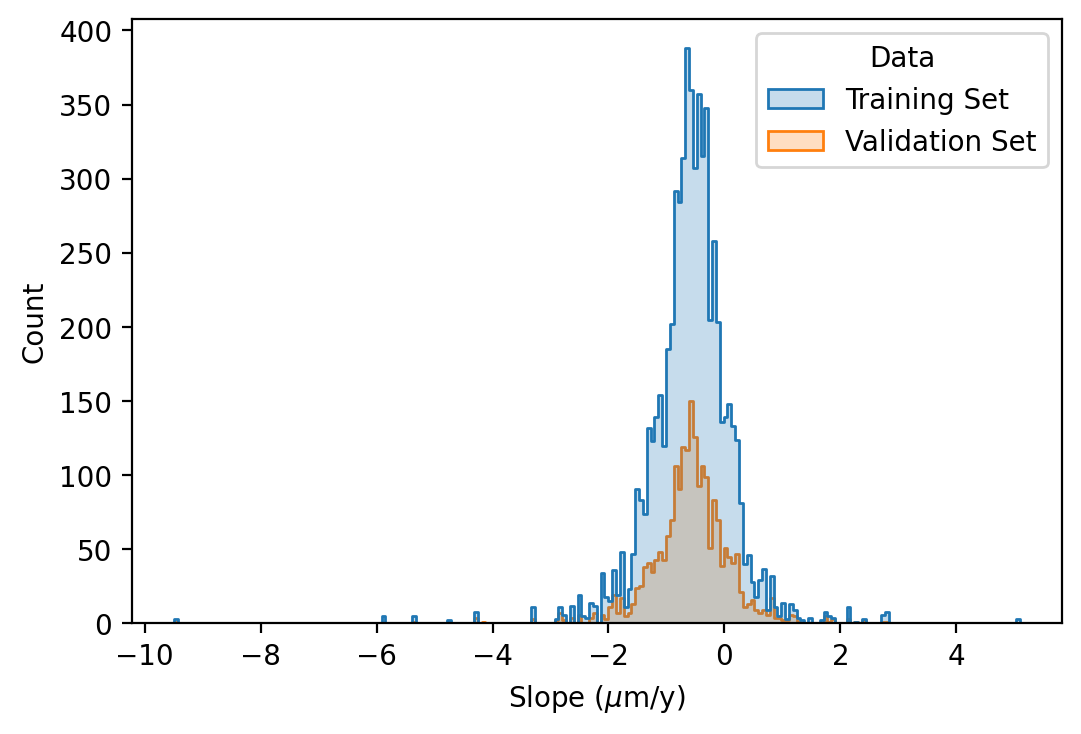

In [4]:

for batch_idx, (_, targets, _) in enumerate(train_loader):
    targets = Variable(targets.view(targets.shape[0],-1))

    if batch_idx == 0:
        true_scores = targets.cpu().numpy()
    else:
        true_scores = np.append(true_scores, targets.cpu().numpy(), axis = 0)

for batch_idx, (_, targets, _) in enumerate(valid_loader):
    targets = Variable(targets.view(targets.shape[0],-1))

    if batch_idx == 0:
        valtrue_scores = targets.cpu().numpy()
    else:
        valtrue_scores = np.append(valtrue_scores, targets.cpu().numpy(), axis = 0)

from scipy.stats import ks_2samp
dfx = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': true_scores.ravel().tolist(), 'Data':'Training Set'})
dfy = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': valtrue_scores.ravel().tolist(), 'Data':'Validation Set'})
df = pd.concat(axis=0, ignore_index=True, objs=[dfx,dfy])



fig,ax = plt.subplots()
sns.histplot(df,x='Slope ($\mu$m/y)',hue='Data',ax=ax, element='step')


In [5]:
print(len(true_scores), len(valtrue_scores))

6421 2141


In [6]:
torch.cuda.empty_cache()
tl = iter(train_loader)
dat,_,_ = next(tl)
bs, ts, C, H, W = dat.shape
n_out = 1
print(ts)

model = CNNLSTMNet(channels = C, ts = ts, n_out = n_out, device = device).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1)  #,momentum=0.9, nesterov=True)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[120], gamma= 0.1)
criterion = nn.MSELoss()  # this is for regression mean squared loss

5


In [7]:
epochs = 200
best_loss =float('inf')
ep, trainloss, validloss, testloss = [],[],[],[]
testep, totloss = [],[]
besttrloss, bestvalloss, besttsloss = 0,0,0
for epoch in range(1,epochs+1):
    model.train()
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    trloss = 0
    for batch_idx, (data, targets, _) in loop:
        optimizer.zero_grad() 
        data = Variable(data).to(device)
        targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

        #forward pass
        scores = model(data)
        loss = criterion(scores, targets)
        trloss += loss.item()
        #backward pass   
        loss.backward()

        #gradient descent
        optimizer.step()
        loop.set_description(f"Epoch [{epoch}/{epochs}]")
        loop.set_postfix(batch_loss = loss.item(), running_loss = trloss )
    scheduler.step()

    model.eval()
    valloss = 0
    with torch.no_grad():
        for data, targets, _ in valid_loader:
            data = Variable(data).to(device)
            targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

            
            scores = model(data)
            loss = criterion(scores, targets)

            valloss += loss.item()

    if valloss < best_loss:
        tsloss = 0
        with torch.no_grad():
            for data, targets, _ in test_loader:
                data = Variable(data).to(device)
                targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

                
                scores = model(data)
                loss = criterion(scores, targets)

                tsloss += loss.item()
            testloss += [tsloss]
            testep += [epoch]
        to_print = "Train Loss: {:.4f} | Valid Loss: {:.4f} ===========> {:.4f} | Test Loss: {:.4f} | Saving model...".format(trloss, best_loss, valloss, tsloss)
        best_loss = valloss
        bestvalloss = valloss
        besttrloss = trloss
        besttsloss = tsloss
        best_e = epoch
        torch.save(model.state_dict(),'state_dict_ts5_3.pt')
        #best_model = copy.deepcopy(model)
    else:
        to_print = "Train Loss: {:.4f} | Valid Loss: {:.4f}".format(trloss, valloss)

    print(to_print)
    ep+=[epoch]
    trainloss += [trloss]
    validloss += [valloss]
    totloss += [trloss + valloss]

Epoch [1/200]: 100%|██████████| 101/101 [00:29<00:00,  3.38it/s, batch_loss=1.59, running_loss=55.6]


Train Loss: 55.6211 | Valid Loss: inf ===========> 19.7226 | Test Loss: 20.7778 | Saving model...


Epoch [2/200]: 100%|██████████| 101/101 [00:30<00:00,  3.31it/s, batch_loss=0.263, running_loss=54]


Train Loss: 53.9614 | Valid Loss: 19.7226 ===========> 17.6821 | Test Loss: 17.8966 | Saving model...


Epoch [3/200]: 100%|██████████| 101/101 [00:30<00:00,  3.34it/s, batch_loss=0.374, running_loss=53]


Train Loss: 53.0284 | Valid Loss: 17.6821 ===========> 17.1218 | Test Loss: 17.6236 | Saving model...


Epoch [4/200]: 100%|██████████| 101/101 [00:30<00:00,  3.34it/s, batch_loss=0.472, running_loss=52.8]


Train Loss: 52.7936 | Valid Loss: 17.1218 ===========> 16.8661 | Test Loss: 17.3075 | Saving model...


Epoch [5/200]: 100%|██████████| 101/101 [00:29<00:00,  3.42it/s, batch_loss=0.403, running_loss=51]


Train Loss: 51.0126 | Valid Loss: 16.8661 ===========> 16.6038 | Test Loss: 16.9780 | Saving model...


Epoch [6/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.204, running_loss=49.5]


Train Loss: 49.5091 | Valid Loss: 16.6038 ===========> 16.3441 | Test Loss: 16.3837 | Saving model...


Epoch [7/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.252, running_loss=47.4]


Train Loss: 47.4253 | Valid Loss: 22.6334


Epoch [8/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.649, running_loss=47.2]


Train Loss: 47.1972 | Valid Loss: 25.0267


Epoch [9/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.365, running_loss=44.8]


Train Loss: 44.7973 | Valid Loss: 19.0805


Epoch [10/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.354, running_loss=43.7]


Train Loss: 43.7159 | Valid Loss: 16.3441 ===========> 14.9667 | Test Loss: 15.2881 | Saving model...


Epoch [11/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.229, running_loss=40.5]


Train Loss: 40.4898 | Valid Loss: 15.3325


Epoch [12/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.147, running_loss=41.8]


Train Loss: 41.8467 | Valid Loss: 15.4857


Epoch [13/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.144, running_loss=35.3]


Train Loss: 35.2983 | Valid Loss: 14.9667 ===========> 14.2929 | Test Loss: 13.9134 | Saving model...


Epoch [14/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.172, running_loss=31.3]


Train Loss: 31.2887 | Valid Loss: 14.8478


Epoch [15/200]: 100%|██████████| 101/101 [00:29<00:00,  3.42it/s, batch_loss=0.244, running_loss=29.9]


Train Loss: 29.8839 | Valid Loss: 14.6966


Epoch [16/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.261, running_loss=26.6]


Train Loss: 26.5781 | Valid Loss: 14.5739


Epoch [17/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.108, running_loss=25.3]


Train Loss: 25.2630 | Valid Loss: 14.4720


Epoch [18/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.74, running_loss=21.9]


Train Loss: 21.9107 | Valid Loss: 26.1731


Epoch [19/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.0766, running_loss=20.5]


Train Loss: 20.5254 | Valid Loss: 14.2929 ===========> 13.6178 | Test Loss: 13.7394 | Saving model...


Epoch [20/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.102, running_loss=16.7]


Train Loss: 16.7301 | Valid Loss: 16.0253


Epoch [21/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.116, running_loss=13.6]


Train Loss: 13.5738 | Valid Loss: 13.6178 ===========> 13.1319 | Test Loss: 12.3061 | Saving model...


Epoch [22/200]: 100%|██████████| 101/101 [00:29<00:00,  3.42it/s, batch_loss=0.491, running_loss=14.8]


Train Loss: 14.7698 | Valid Loss: 13.7683


Epoch [23/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.271, running_loss=12.4]


Train Loss: 12.4417 | Valid Loss: 17.9776


Epoch [24/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.0725, running_loss=10.4]


Train Loss: 10.3742 | Valid Loss: 13.1319 ===========> 12.7665 | Test Loss: 12.0071 | Saving model...


Epoch [25/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.0808, running_loss=9.22]


Train Loss: 9.2153 | Valid Loss: 12.7665 ===========> 12.3428 | Test Loss: 12.2286 | Saving model...


Epoch [26/200]: 100%|██████████| 101/101 [00:29<00:00,  3.42it/s, batch_loss=0.0476, running_loss=7.97]


Train Loss: 7.9652 | Valid Loss: 13.8109


Epoch [27/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.0629, running_loss=6.73]


Train Loss: 6.7322 | Valid Loss: 14.7439


Epoch [28/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.0224, running_loss=6.45]


Train Loss: 6.4543 | Valid Loss: 12.3428 ===========> 12.2592 | Test Loss: 11.9682 | Saving model...


Epoch [29/200]: 100%|██████████| 101/101 [00:29<00:00,  3.42it/s, batch_loss=0.0984, running_loss=5.61]


Train Loss: 5.6058 | Valid Loss: 12.9202


Epoch [30/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.102, running_loss=6.16]


Train Loss: 6.1579 | Valid Loss: 13.0898


Epoch [31/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.0328, running_loss=4.89]


Train Loss: 4.8883 | Valid Loss: 12.2592 ===========> 11.5819 | Test Loss: 11.2909 | Saving model...


Epoch [32/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.0602, running_loss=4.42]


Train Loss: 4.4209 | Valid Loss: 11.8457


Epoch [33/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.0315, running_loss=4.17]


Train Loss: 4.1727 | Valid Loss: 11.7385


Epoch [34/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.0609, running_loss=3.86]


Train Loss: 3.8630 | Valid Loss: 14.0970


Epoch [35/200]: 100%|██████████| 101/101 [00:29<00:00,  3.42it/s, batch_loss=0.0221, running_loss=3.66]


Train Loss: 3.6578 | Valid Loss: 11.7928


Epoch [36/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.0353, running_loss=3.14]


Train Loss: 3.1403 | Valid Loss: 11.9116


Epoch [37/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.0346, running_loss=3.23]


Train Loss: 3.2332 | Valid Loss: 12.2642


Epoch [38/200]: 100%|██████████| 101/101 [00:29<00:00,  3.42it/s, batch_loss=0.0264, running_loss=3.1]


Train Loss: 3.1029 | Valid Loss: 12.4947


Epoch [39/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.038, running_loss=2.98]


Train Loss: 2.9847 | Valid Loss: 12.1445


Epoch [40/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.025, running_loss=3.01]


Train Loss: 3.0114 | Valid Loss: 12.4903


Epoch [41/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.02, running_loss=2.79]


Train Loss: 2.7922 | Valid Loss: 11.5819 ===========> 11.5643 | Test Loss: 11.3017 | Saving model...


Epoch [42/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.0331, running_loss=2.57]


Train Loss: 2.5713 | Valid Loss: 11.7069


Epoch [43/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.0296, running_loss=2.62]


Train Loss: 2.6172 | Valid Loss: 12.0600


Epoch [44/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.0204, running_loss=2.29]


Train Loss: 2.2875 | Valid Loss: 11.7717


Epoch [45/200]: 100%|██████████| 101/101 [00:29<00:00,  3.45it/s, batch_loss=0.0349, running_loss=2.36]


Train Loss: 2.3581 | Valid Loss: 11.5712


Epoch [46/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.0359, running_loss=2.37]


Train Loss: 2.3677 | Valid Loss: 11.6814


Epoch [47/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.0167, running_loss=2.22]


Train Loss: 2.2182 | Valid Loss: 11.5643 ===========> 11.4398 | Test Loss: 11.5363 | Saving model...


Epoch [48/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.0184, running_loss=2.07]


Train Loss: 2.0748 | Valid Loss: 11.6477


Epoch [49/200]: 100%|██████████| 101/101 [00:29<00:00,  3.45it/s, batch_loss=0.0251, running_loss=2.1]


Train Loss: 2.1025 | Valid Loss: 11.8398


Epoch [50/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.0225, running_loss=1.98]


Train Loss: 1.9809 | Valid Loss: 11.4859


Epoch [51/200]: 100%|██████████| 101/101 [00:29<00:00,  3.45it/s, batch_loss=0.0212, running_loss=2.06]


Train Loss: 2.0569 | Valid Loss: 11.4398 ===========> 11.2636 | Test Loss: 11.0643 | Saving model...


Epoch [52/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.0167, running_loss=2.12]


Train Loss: 2.1172 | Valid Loss: 11.2769


Epoch [53/200]: 100%|██████████| 101/101 [00:29<00:00,  3.46it/s, batch_loss=0.0111, running_loss=2.07]


Train Loss: 2.0734 | Valid Loss: 11.3040


Epoch [54/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.0255, running_loss=1.88]


Train Loss: 1.8848 | Valid Loss: 11.5854


Epoch [55/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.0179, running_loss=1.82]


Train Loss: 1.8236 | Valid Loss: 11.3954


Epoch [56/200]: 100%|██████████| 101/101 [00:29<00:00,  3.45it/s, batch_loss=0.0405, running_loss=1.76]


Train Loss: 1.7596 | Valid Loss: 11.2636 ===========> 11.1005 | Test Loss: 10.8849 | Saving model...


Epoch [57/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.0216, running_loss=1.86]


Train Loss: 1.8558 | Valid Loss: 11.4019


Epoch [58/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.0161, running_loss=1.83]


Train Loss: 1.8322 | Valid Loss: 11.1911


Epoch [59/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.0166, running_loss=1.72]


Train Loss: 1.7153 | Valid Loss: 11.4600


Epoch [60/200]: 100%|██████████| 101/101 [00:29<00:00,  3.45it/s, batch_loss=0.0111, running_loss=1.67]


Train Loss: 1.6657 | Valid Loss: 11.1180


Epoch [61/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.0223, running_loss=1.87]


Train Loss: 1.8677 | Valid Loss: 11.4252


Epoch [62/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.0184, running_loss=1.69]


Train Loss: 1.6893 | Valid Loss: 11.6943


Epoch [63/200]: 100%|██████████| 101/101 [00:29<00:00,  3.45it/s, batch_loss=0.0272, running_loss=1.69]


Train Loss: 1.6858 | Valid Loss: 11.3605


Epoch [64/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.0252, running_loss=1.61]


Train Loss: 1.6090 | Valid Loss: 11.5180


Epoch [65/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.0208, running_loss=1.67]


Train Loss: 1.6688 | Valid Loss: 11.1419


Epoch [66/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.0148, running_loss=1.56]


Train Loss: 1.5579 | Valid Loss: 11.2655


Epoch [67/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.0349, running_loss=1.63]


Train Loss: 1.6312 | Valid Loss: 11.1184


Epoch [68/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.0229, running_loss=1.51]


Train Loss: 1.5124 | Valid Loss: 11.3794


Epoch [69/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.026, running_loss=1.45]


Train Loss: 1.4528 | Valid Loss: 11.1005 ===========> 11.0013 | Test Loss: 10.8503 | Saving model...


Epoch [70/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.0142, running_loss=1.59]


Train Loss: 1.5920 | Valid Loss: 11.2679


Epoch [71/200]: 100%|██████████| 101/101 [00:29<00:00,  3.46it/s, batch_loss=0.0207, running_loss=1.47]


Train Loss: 1.4727 | Valid Loss: 11.4453


Epoch [72/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.0266, running_loss=1.54]


Train Loss: 1.5402 | Valid Loss: 11.3769


Epoch [73/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.0219, running_loss=1.53]


Train Loss: 1.5292 | Valid Loss: 11.4065


Epoch [74/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.0136, running_loss=1.36]


Train Loss: 1.3624 | Valid Loss: 11.0532


Epoch [75/200]: 100%|██████████| 101/101 [00:29<00:00,  3.46it/s, batch_loss=0.0127, running_loss=1.45]


Train Loss: 1.4497 | Valid Loss: 11.5429


Epoch [76/200]: 100%|██████████| 101/101 [00:29<00:00,  3.45it/s, batch_loss=0.0124, running_loss=1.32]


Train Loss: 1.3222 | Valid Loss: 11.2302


Epoch [77/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.00941, running_loss=1.34]


Train Loss: 1.3402 | Valid Loss: 11.0788


Epoch [78/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.0126, running_loss=1.4]


Train Loss: 1.4008 | Valid Loss: 11.0404


Epoch [79/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.00936, running_loss=1.32]


Train Loss: 1.3219 | Valid Loss: 11.3363


Epoch [80/200]: 100%|██████████| 101/101 [00:29<00:00,  3.45it/s, batch_loss=0.0145, running_loss=1.26]


Train Loss: 1.2640 | Valid Loss: 11.4394


Epoch [81/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.0104, running_loss=1.25]


Train Loss: 1.2480 | Valid Loss: 11.1863


Epoch [82/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.0086, running_loss=1.28]


Train Loss: 1.2816 | Valid Loss: 11.4138


Epoch [83/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.00871, running_loss=1.23]


Train Loss: 1.2350 | Valid Loss: 11.2486


Epoch [84/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.0144, running_loss=1.31]


Train Loss: 1.3069 | Valid Loss: 11.2005


Epoch [85/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.0103, running_loss=1.23]


Train Loss: 1.2252 | Valid Loss: 11.0593


Epoch [86/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.0115, running_loss=1.2]


Train Loss: 1.2026 | Valid Loss: 11.1998


Epoch [87/200]: 100%|██████████| 101/101 [00:29<00:00,  3.42it/s, batch_loss=0.0195, running_loss=1.23]


Train Loss: 1.2273 | Valid Loss: 11.0669


Epoch [88/200]: 100%|██████████| 101/101 [00:29<00:00,  3.42it/s, batch_loss=0.0113, running_loss=1.21]


Train Loss: 1.2066 | Valid Loss: 11.0978


Epoch [89/200]: 100%|██████████| 101/101 [00:29<00:00,  3.42it/s, batch_loss=0.0116, running_loss=1.19]


Train Loss: 1.1895 | Valid Loss: 11.1937


Epoch [90/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.0111, running_loss=1.22]


Train Loss: 1.2153 | Valid Loss: 11.1733


Epoch [91/200]: 100%|██████████| 101/101 [00:29<00:00,  3.41it/s, batch_loss=0.0258, running_loss=1.18]


Train Loss: 1.1830 | Valid Loss: 11.1296


Epoch [92/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.0261, running_loss=1.19]


Train Loss: 1.1866 | Valid Loss: 11.1739


Epoch [93/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.0323, running_loss=1.17]


Train Loss: 1.1683 | Valid Loss: 11.2160


Epoch [94/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.00729, running_loss=1.2]


Train Loss: 1.1978 | Valid Loss: 11.0013 ===========> 10.8678 | Test Loss: 10.7069 | Saving model...


Epoch [95/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.0205, running_loss=1.14]


Train Loss: 1.1412 | Valid Loss: 11.1659


Epoch [96/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.00816, running_loss=1.12]


Train Loss: 1.1235 | Valid Loss: 11.2729


Epoch [97/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.0111, running_loss=1.12]


Train Loss: 1.1225 | Valid Loss: 11.1133


Epoch [98/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.0156, running_loss=1.1]


Train Loss: 1.1047 | Valid Loss: 11.5498


Epoch [99/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.0108, running_loss=1.17]


Train Loss: 1.1704 | Valid Loss: 11.2243


Epoch [100/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.011, running_loss=1.15]


Train Loss: 1.1508 | Valid Loss: 10.8678 ===========> 10.8546 | Test Loss: 10.7728 | Saving model...


Epoch [101/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.0107, running_loss=1.13]


Train Loss: 1.1299 | Valid Loss: 11.2496


Epoch [102/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.0133, running_loss=1.07]


Train Loss: 1.0716 | Valid Loss: 10.8546 ===========> 10.8141 | Test Loss: 10.7610 | Saving model...


Epoch [103/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.0182, running_loss=1.12]


Train Loss: 1.1173 | Valid Loss: 10.9004


Epoch [104/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.00613, running_loss=1.11]


Train Loss: 1.1125 | Valid Loss: 10.9156


Epoch [105/200]: 100%|██████████| 101/101 [00:29<00:00,  3.45it/s, batch_loss=0.012, running_loss=1.09]


Train Loss: 1.0931 | Valid Loss: 11.1481


Epoch [106/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.0058, running_loss=1.07]


Train Loss: 1.0739 | Valid Loss: 10.9727


Epoch [107/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.0105, running_loss=1.08]


Train Loss: 1.0803 | Valid Loss: 10.9521


Epoch [108/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.00748, running_loss=1.05]


Train Loss: 1.0503 | Valid Loss: 11.2367


Epoch [109/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.015, running_loss=1.05]


Train Loss: 1.0525 | Valid Loss: 11.1776


Epoch [110/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.0101, running_loss=1.07]


Train Loss: 1.0747 | Valid Loss: 10.9847


Epoch [111/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.00936, running_loss=1.05]


Train Loss: 1.0491 | Valid Loss: 10.9950


Epoch [112/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.0149, running_loss=1.05]


Train Loss: 1.0482 | Valid Loss: 11.0861


Epoch [113/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.00626, running_loss=1.01]


Train Loss: 1.0132 | Valid Loss: 11.0460


Epoch [114/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.00874, running_loss=0.987]


Train Loss: 0.9868 | Valid Loss: 11.3000


Epoch [115/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.0107, running_loss=1.02]


Train Loss: 1.0206 | Valid Loss: 10.9484


Epoch [116/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.0229, running_loss=1.03]


Train Loss: 1.0284 | Valid Loss: 11.0880


Epoch [117/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.00522, running_loss=0.986]


Train Loss: 0.9862 | Valid Loss: 11.2255


Epoch [118/200]: 100%|██████████| 101/101 [00:29<00:00,  3.45it/s, batch_loss=0.00734, running_loss=0.935]


Train Loss: 0.9346 | Valid Loss: 11.0329


Epoch [119/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.00764, running_loss=1]


Train Loss: 1.0009 | Valid Loss: 11.0096


Epoch [120/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.00656, running_loss=0.947]


Train Loss: 0.9467 | Valid Loss: 10.8657


Epoch [121/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.0104, running_loss=0.918]


Train Loss: 0.9179 | Valid Loss: 10.8545


Epoch [122/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.0185, running_loss=0.89]


Train Loss: 0.8897 | Valid Loss: 10.9870


Epoch [123/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.0137, running_loss=0.925]


Train Loss: 0.9248 | Valid Loss: 10.9184


Epoch [124/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.00401, running_loss=0.868]


Train Loss: 0.8679 | Valid Loss: 11.0639


Epoch [125/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.00866, running_loss=0.867]


Train Loss: 0.8670 | Valid Loss: 10.9494


Epoch [126/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.0103, running_loss=0.862]


Train Loss: 0.8619 | Valid Loss: 10.9199


Epoch [127/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.0125, running_loss=0.83]


Train Loss: 0.8295 | Valid Loss: 10.8936


Epoch [128/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.0133, running_loss=0.861]


Train Loss: 0.8611 | Valid Loss: 11.2674


Epoch [129/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.00511, running_loss=0.828]


Train Loss: 0.8279 | Valid Loss: 10.9735


Epoch [130/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.00898, running_loss=0.82]


Train Loss: 0.8197 | Valid Loss: 10.9167


Epoch [131/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.00879, running_loss=0.835]


Train Loss: 0.8352 | Valid Loss: 10.9718


Epoch [132/200]: 100%|██████████| 101/101 [00:29<00:00,  3.42it/s, batch_loss=0.00574, running_loss=0.797]


Train Loss: 0.7966 | Valid Loss: 10.8580


Epoch [133/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.00732, running_loss=0.82]


Train Loss: 0.8200 | Valid Loss: 10.8892


Epoch [134/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.0104, running_loss=0.808]


Train Loss: 0.8083 | Valid Loss: 10.9217


Epoch [135/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.00657, running_loss=0.815]


Train Loss: 0.8154 | Valid Loss: 10.8755


Epoch [136/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.0113, running_loss=0.811]


Train Loss: 0.8113 | Valid Loss: 10.8530


Epoch [137/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.00704, running_loss=0.777]


Train Loss: 0.7769 | Valid Loss: 10.9124


Epoch [138/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.00928, running_loss=0.784]


Train Loss: 0.7837 | Valid Loss: 11.0534


Epoch [139/200]: 100%|██████████| 101/101 [00:29<00:00,  3.42it/s, batch_loss=0.01, running_loss=0.793]


Train Loss: 0.7934 | Valid Loss: 10.8141 ===========> 10.8014 | Test Loss: 10.7028 | Saving model...


Epoch [140/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.0106, running_loss=0.789]


Train Loss: 0.7888 | Valid Loss: 10.9011


Epoch [141/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.0115, running_loss=0.777]


Train Loss: 0.7769 | Valid Loss: 10.9094


Epoch [142/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.0139, running_loss=0.794]


Train Loss: 0.7938 | Valid Loss: 10.9445


Epoch [143/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.0099, running_loss=0.799]


Train Loss: 0.7988 | Valid Loss: 11.2113


Epoch [144/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.00676, running_loss=0.771]


Train Loss: 0.7709 | Valid Loss: 10.9607


Epoch [145/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.00275, running_loss=0.785]


Train Loss: 0.7850 | Valid Loss: 10.8682


Epoch [146/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.00437, running_loss=0.745]


Train Loss: 0.7449 | Valid Loss: 10.9271


Epoch [147/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.00442, running_loss=0.73]


Train Loss: 0.7297 | Valid Loss: 10.8711


Epoch [148/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.0074, running_loss=0.795]


Train Loss: 0.7951 | Valid Loss: 10.8932


Epoch [149/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.00841, running_loss=0.794]


Train Loss: 0.7945 | Valid Loss: 10.8929


Epoch [150/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.016, running_loss=0.775]


Train Loss: 0.7748 | Valid Loss: 10.8817


Epoch [151/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.006, running_loss=0.753]


Train Loss: 0.7533 | Valid Loss: 11.2842


Epoch [152/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.00823, running_loss=0.782]


Train Loss: 0.7821 | Valid Loss: 10.8874


Epoch [153/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.0176, running_loss=0.774]


Train Loss: 0.7737 | Valid Loss: 10.8313


Epoch [154/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.00609, running_loss=0.775]


Train Loss: 0.7747 | Valid Loss: 11.0228


Epoch [155/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.0112, running_loss=0.78]


Train Loss: 0.7802 | Valid Loss: 11.0079


Epoch [156/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.00495, running_loss=0.79]


Train Loss: 0.7897 | Valid Loss: 11.2945


Epoch [157/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.0149, running_loss=0.788]


Train Loss: 0.7881 | Valid Loss: 10.8773


Epoch [158/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.00955, running_loss=0.79]


Train Loss: 0.7897 | Valid Loss: 10.8603


Epoch [159/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.00662, running_loss=0.779]


Train Loss: 0.7792 | Valid Loss: 11.3533


Epoch [160/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.00725, running_loss=0.772]


Train Loss: 0.7720 | Valid Loss: 10.9211


Epoch [161/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.00865, running_loss=0.766]


Train Loss: 0.7665 | Valid Loss: 10.9998


Epoch [162/200]: 100%|██████████| 101/101 [00:29<00:00,  3.42it/s, batch_loss=0.00859, running_loss=0.749]


Train Loss: 0.7488 | Valid Loss: 10.9299


Epoch [163/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.0125, running_loss=0.753]


Train Loss: 0.7533 | Valid Loss: 10.9093


Epoch [164/200]: 100%|██████████| 101/101 [00:29<00:00,  3.41it/s, batch_loss=0.00668, running_loss=0.777]


Train Loss: 0.7772 | Valid Loss: 10.9968


Epoch [165/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.00642, running_loss=0.74]


Train Loss: 0.7399 | Valid Loss: 10.9907


Epoch [166/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.0127, running_loss=0.77]


Train Loss: 0.7697 | Valid Loss: 10.8542


Epoch [167/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.00757, running_loss=0.784]


Train Loss: 0.7838 | Valid Loss: 10.8797


Epoch [168/200]: 100%|██████████| 101/101 [00:29<00:00,  3.42it/s, batch_loss=0.00689, running_loss=0.774]


Train Loss: 0.7743 | Valid Loss: 10.9410


Epoch [169/200]: 100%|██████████| 101/101 [00:29<00:00,  3.41it/s, batch_loss=0.00541, running_loss=0.74]


Train Loss: 0.7403 | Valid Loss: 10.8895


Epoch [170/200]: 100%|██████████| 101/101 [00:29<00:00,  3.41it/s, batch_loss=0.00854, running_loss=0.738]


Train Loss: 0.7378 | Valid Loss: 10.8976


Epoch [171/200]: 100%|██████████| 101/101 [00:29<00:00,  3.41it/s, batch_loss=0.0107, running_loss=0.753]


Train Loss: 0.7534 | Valid Loss: 10.8955


Epoch [172/200]: 100%|██████████| 101/101 [00:29<00:00,  3.41it/s, batch_loss=0.00533, running_loss=0.752]


Train Loss: 0.7525 | Valid Loss: 10.9619


Epoch [173/200]: 100%|██████████| 101/101 [00:29<00:00,  3.42it/s, batch_loss=0.00731, running_loss=0.764]


Train Loss: 0.7643 | Valid Loss: 10.8309


Epoch [174/200]: 100%|██████████| 101/101 [00:29<00:00,  3.41it/s, batch_loss=0.00332, running_loss=0.707]


Train Loss: 0.7074 | Valid Loss: 10.9713


Epoch [175/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.0053, running_loss=0.753]


Train Loss: 0.7525 | Valid Loss: 11.0601


Epoch [176/200]: 100%|██████████| 101/101 [00:29<00:00,  3.42it/s, batch_loss=0.00757, running_loss=0.764]


Train Loss: 0.7639 | Valid Loss: 11.2608


Epoch [177/200]: 100%|██████████| 101/101 [00:29<00:00,  3.42it/s, batch_loss=0.00361, running_loss=0.731]


Train Loss: 0.7308 | Valid Loss: 10.9622


Epoch [178/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.0163, running_loss=0.752]


Train Loss: 0.7525 | Valid Loss: 10.9646


Epoch [179/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.00708, running_loss=0.778]


Train Loss: 0.7777 | Valid Loss: 10.9254


Epoch [180/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.00435, running_loss=0.763]


Train Loss: 0.7626 | Valid Loss: 10.9247


Epoch [181/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.00456, running_loss=0.749]


Train Loss: 0.7487 | Valid Loss: 10.8677


Epoch [182/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.0135, running_loss=0.749]


Train Loss: 0.7489 | Valid Loss: 11.0341


Epoch [183/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.00707, running_loss=0.765]


Train Loss: 0.7646 | Valid Loss: 10.8879


Epoch [184/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.0143, running_loss=0.756]


Train Loss: 0.7558 | Valid Loss: 10.9931


Epoch [185/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.0176, running_loss=0.757]


Train Loss: 0.7573 | Valid Loss: 10.8793


Epoch [186/200]: 100%|██████████| 101/101 [00:29<00:00,  3.42it/s, batch_loss=0.00748, running_loss=0.731]


Train Loss: 0.7315 | Valid Loss: 10.8927


Epoch [187/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.0101, running_loss=0.748]


Train Loss: 0.7479 | Valid Loss: 10.8171


Epoch [188/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.0212, running_loss=0.728]


Train Loss: 0.7277 | Valid Loss: 10.8259


Epoch [189/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.00527, running_loss=0.759]


Train Loss: 0.7586 | Valid Loss: 10.8273


Epoch [190/200]: 100%|██████████| 101/101 [00:29<00:00,  3.42it/s, batch_loss=0.0236, running_loss=0.739]


Train Loss: 0.7391 | Valid Loss: 10.8609


Epoch [191/200]: 100%|██████████| 101/101 [00:29<00:00,  3.44it/s, batch_loss=0.00728, running_loss=0.727]


Train Loss: 0.7275 | Valid Loss: 10.8669


Epoch [192/200]: 100%|██████████| 101/101 [00:29<00:00,  3.42it/s, batch_loss=0.00746, running_loss=0.717]


Train Loss: 0.7170 | Valid Loss: 10.8862


Epoch [193/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.00682, running_loss=0.737]


Train Loss: 0.7374 | Valid Loss: 10.8063


Epoch [194/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.00469, running_loss=0.722]


Train Loss: 0.7225 | Valid Loss: 10.9214


Epoch [195/200]: 100%|██████████| 101/101 [00:29<00:00,  3.42it/s, batch_loss=0.00689, running_loss=0.726]


Train Loss: 0.7258 | Valid Loss: 10.9324


Epoch [196/200]: 100%|██████████| 101/101 [00:29<00:00,  3.42it/s, batch_loss=0.0117, running_loss=0.757]


Train Loss: 0.7575 | Valid Loss: 11.1344


Epoch [197/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.00695, running_loss=0.719]


Train Loss: 0.7187 | Valid Loss: 10.8230


Epoch [198/200]: 100%|██████████| 101/101 [00:29<00:00,  3.42it/s, batch_loss=0.00648, running_loss=0.698]


Train Loss: 0.6983 | Valid Loss: 10.8822


Epoch [199/200]: 100%|██████████| 101/101 [00:29<00:00,  3.43it/s, batch_loss=0.0126, running_loss=0.755]


Train Loss: 0.7550 | Valid Loss: 11.2937


Epoch [200/200]: 100%|██████████| 101/101 [00:29<00:00,  3.42it/s, batch_loss=0.00429, running_loss=0.721]


Train Loss: 0.7208 | Valid Loss: 10.8672


Train Loss: 0.7934 | Valid Loss: 10.8014 | Test Loss on Best Model: 10.7028


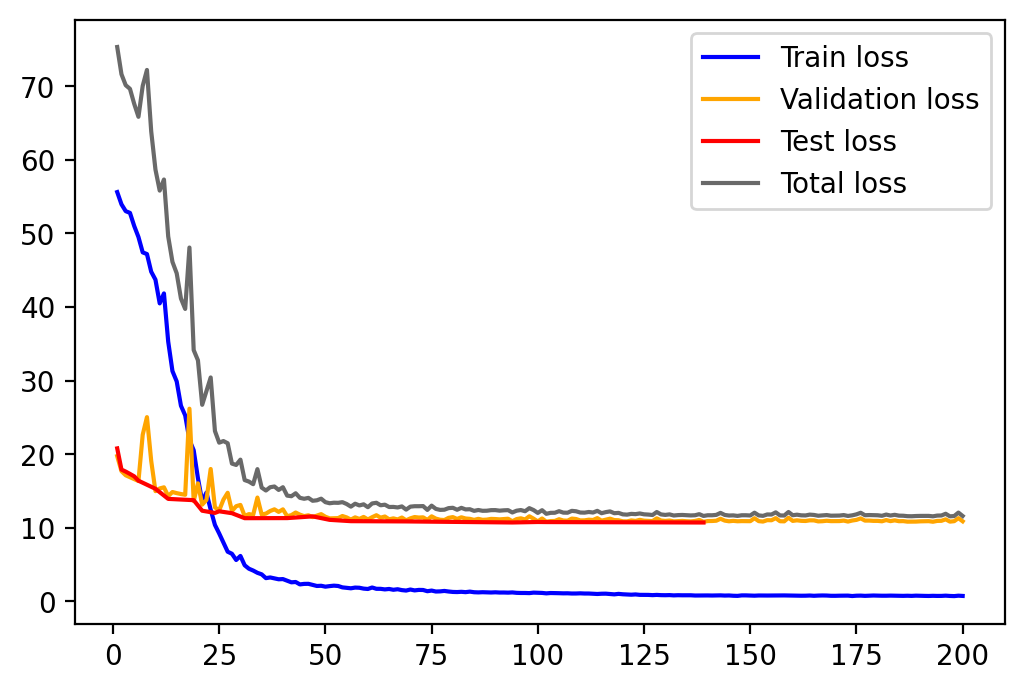

In [10]:
print("Train Loss: {:.4f} | Valid Loss: {:.4f} | Test Loss on Best Model: {:.4f}".format(besttrloss, bestvalloss, besttsloss))
plt.plot(ep,trainloss,color='blue', label = 'Train loss')
plt.plot(ep, validloss, color = 'orange',label = 'Validation loss')
plt.plot(testep, testloss, color = 'red',label = 'Test loss')
plt.plot(ep, totloss, color = 'dimgray',label = 'Total loss')
plt.legend()
plt.show()

In [11]:
tsloss = 0
model.load_state_dict(torch.load('state_dict_ts5_3.pt'))
model.eval()
with torch.no_grad():
    for batch_idx, (data, targets, _) in enumerate(test_loader):
        data = Variable(data).to(device)
        targets = Variable(targets.view(targets.shape[0],-1)).to(device)

        
        scores = model(data)
        loss = criterion(scores, targets)

        if batch_idx == 0:
            true_scores = targets.cpu().numpy()
            pred_scores = scores.cpu().numpy()
        else:
            true_scores = np.append(true_scores, targets.cpu().numpy(), axis = 0)
            pred_scores = np.append(pred_scores, scores.cpu().numpy(), axis = 0)


        tsloss += loss.item()


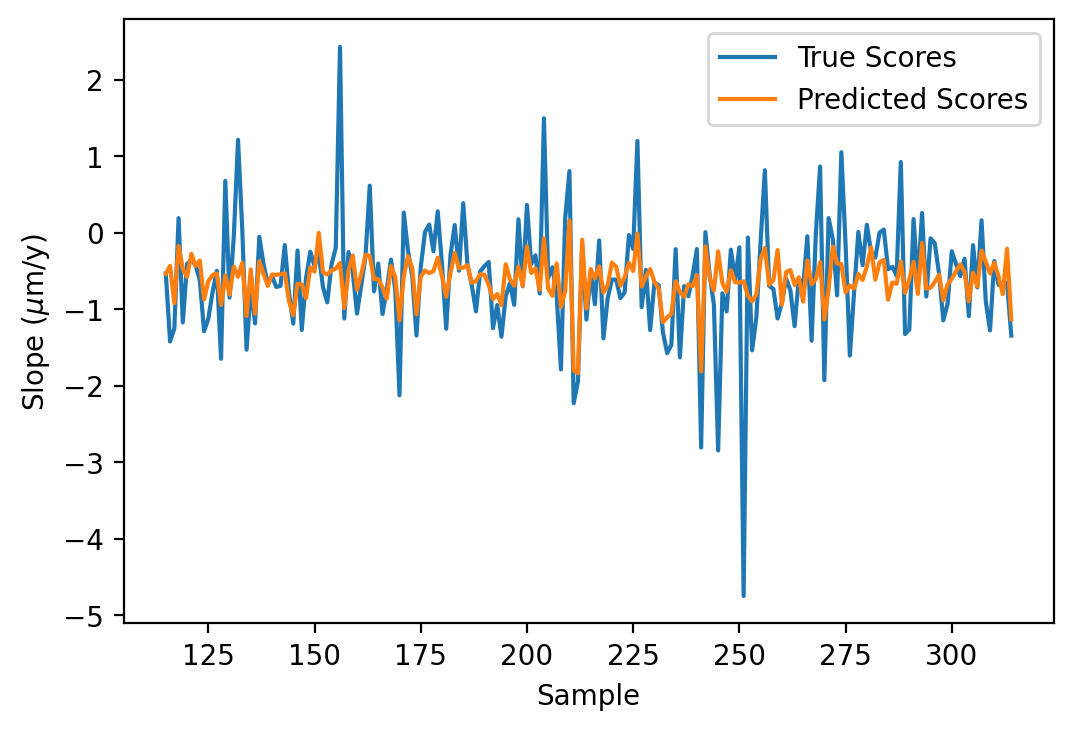

In [12]:
idx = np.array([i+1 for i in range(len(true_scores))])
size = 200
r = np.random.randint(len(idx)-size)
plt.plot(idx[r:r+size], true_scores[r:r+size], label = "True Scores")
plt.plot(idx[r:r+size], pred_scores[r:r+size],label = "Predicted Scores")
plt.ylabel('Slope ($\mu$m/y)')
plt.xlabel('Sample')
plt.legend()
plt.show()

<AxesSubplot:xlabel='Slope ($\\mu$m/y)', ylabel='Count'>

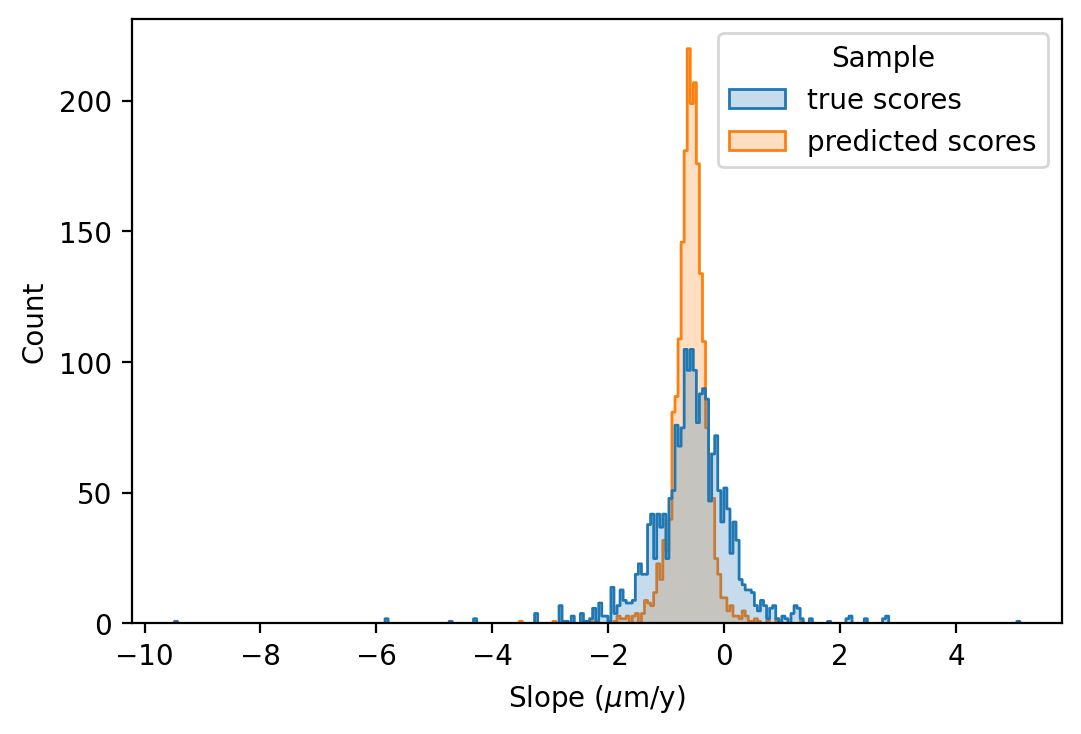

In [13]:
from scipy.stats import ks_2samp
dfx = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': true_scores.ravel().tolist(), 'Sample':'true scores'})
dfy = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': pred_scores.ravel().tolist(), 'Sample':'predicted scores'})
df = pd.concat(axis=0, ignore_index=True, objs=[dfx,dfy])



fig,ax = plt.subplots()
sns.histplot(df,x='Slope ($\mu$m/y)',hue='Sample',ax=ax, element='step')


In [14]:
print(ks_2samp(true_scores.ravel().tolist(),pred_scores.ravel().tolist()))

KstestResult(statistic=0.20364315740308267, pvalue=3.012069394808932e-39)


In [15]:
df.to_csv('predscores.csv')

In [16]:
ndf = pd.DataFrame({'ep': ep,
'train': trainloss,
'valid': validloss,'total':totloss})
ndf.to_csv('losses.csv')

ndf = pd.DataFrame({'ep': testep, 'test':testloss})
ndf.to_csv('testl.csv')

In [17]:
import pandas as pd
import numpy as np

In [18]:
df = pd.read_csv('predscores.csv')

In [19]:
true = np.array(df[df['Sample'] == 'true scores']['Slope ($\mu$m/y)'].tolist())

In [20]:
pred = np.array(df[df['Sample'] == 'predicted scores']['Slope ($\mu$m/y)'].tolist())

In [21]:
from sklearn.metrics import r2_score

coefficient_of_dermination = r2_score(true, pred)

In [22]:
coefficient_of_dermination

0.40365019391688917

In [23]:
import scipy
def rsquared(x, y):

    """ Return R^2 where x and y are array-like."""

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value**2

In [24]:
rsquared(true, pred)

0.48194722572547055

In [25]:
scipy.stats.spearmanr(true, pred)

SpearmanrResult(correlation=0.6683150610310332, pvalue=3.5821149972731126e-277)

In [26]:
scipy.stats.pearsonr(true, pred)

(0.6942241898158483, 8.280631105345388e-308)